In [1]:
import numpy as np
import json
from matplotlib import pyplot as plt
import os
import Hamiltonians.helper as helper
import Hamiltonians.hamiltonians as ham
from sklearn.cluster import DBSCAN

plt.rcParams['figure.dpi'] = 150
system = "linear_4"
keys = ["run"+str(i) for i in range(1,2)]
colors = ["steelblue","g","gray"]
n_points = 0
for i in range(len(keys)):
    dir_path = keys[i] +"/results"
    n_points += len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))])
data = {"mix_energy": [], "mix_shots": [],"mix_moments":[], "qwc_energy": [], "qwc_shots":[],"qwc_moments":[], "cs_energy":[], "cs_shots":[],"cs_moments":[]}

In [2]:
data

{'mix_energy': [],
 'mix_shots': [],
 'mix_moments': [],
 'qwc_energy': [],
 'qwc_shots': [],
 'qwc_moments': [],
 'cs_energy': [],
 'cs_shots': [],
 'cs_moments': []}

<h1> Step 1) Collect and Organize Results </h1>

In [3]:
with open("saved_hamiltonians/linear_6_1.json") as fp:
    k = json.load(fp)
ham_qm = ham.Hamiltonian(list(k.keys()), [complex(s) for s in list(k.values())])

In [4]:
ham_mat = ham_qm.to_matrix()

In [5]:
n_points

104

In [6]:
for j in range(len(keys)):
    dir_path = keys[j] +"/results"
    nps = len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))])
    for i in range(nps):
        with open(dir_path+"/"+str(i)+".json") as fp:
            dat_ = json.load(fp)
            for key in data:
                data[key] += [dat_[key]]

In [7]:
for key in data:
    data[key] = np.array(data[key]).T

**Remove Outliers Using DBSCAN Protocol ($\epsilon = 5$, $minsamples = 5$)**

In [8]:
data["mix_energy"].shape

(6, 104)

In [31]:
ks = [1,2,3,4,5,6]
data_no_outliers = {"mix_energy": [], "mix_shots": [],"mix_moments":[], "qwc_energy": [], "qwc_shots":[],"qwc_moments":[], "cs_energy":[], "cs_shots":[],"cs_moments":[]}
data_no_outliers_save = {"mix_energy": [], "mix_shots": [],"mix_moments":[], "qwc_energy": [], "qwc_shots":[],"qwc_moments":[], "cs_energy":[], "cs_shots":[],"cs_moments":[]}
for key in ["mix_energy", "cs_energy","qwc_energy"]:
    data_no_outliers[key] = [0]*len(ks)
    data_no_outliers_save[key] = [0]*len(ks)
    for i in range(len(ks)):
        X = np.array(data[key][i]).reshape(-1,1)
        clustering = DBSCAN(eps=5, min_samples=5).fit(X)
        clustering.labels_
        Y = np.array([np.inf]*len(X))
        indeces = np.where(clustering.labels_ != -1)[0]
        Y[indeces] = X[indeces].reshape(1,-1)[0]

        data_no_outliers[key][i] = X[indeces].reshape(1,-1)[0]
        data_no_outliers_save[key][i] = Y

In [32]:
import pandas as pd

row_names = {"system":[], "method":[], "shots":[], "computer":[]}
for i in range(ks[-1]*2):
    row_names["Moment " + str(i)] = []
for k in ks:
    row_names["PDS " + str(k)] = []
df = pd.DataFrame(row_names)
print(df)
from tqdm import tqdm
for key_ in ["mix", "qwc", "cs"]:
    for i in tqdm(range(n_points)):
        row = [system, key_,data[key_+"_shots"][i],"qasm simulator"]
        for j in range(ks[-1]*2):
            row += [complex(data[key_+"_moments"][j][i]).real]
        for k in range(len(ks)):
            row += [complex(data[key_+"_energy"][k][i]).real]
        df.loc[len(df.index)] = row
print(df)
df.to_csv('results.csv', index=False)


Empty DataFrame
Columns: [system, method, shots, computer, Moment 0, Moment 1, Moment 2, Moment 3, Moment 4, Moment 5, Moment 6, Moment 7, Moment 8, Moment 9, Moment 10, Moment 11, PDS 1, PDS 2, PDS 3, PDS 4, PDS 5, PDS 6]
Index: []

[0 rows x 22 columns]


100%|████████████████████████████████████████████████████████████████████████████████| 104/104 [00:00<00:00, 170.99it/s]


       system method   shots        computer  Moment 0  Moment 1   Moment 2  \
0    linear_4    mix  471600  qasm simulator       1.0  1.927971  12.754995   
1    linear_4    mix  471600  qasm simulator       1.0  1.919033  13.222923   
2    linear_4    mix  471600  qasm simulator       1.0  2.026288  12.404837   
3    linear_4    mix  471600  qasm simulator       1.0  1.956362  12.590957   
4    linear_4    mix  471600  qasm simulator       1.0  1.930074  12.856993   
..        ...    ...     ...             ...       ...       ...        ...   
307  linear_4     cs  471663  qasm simulator       1.0  1.920969  12.739073   
308  linear_4     cs  471663  qasm simulator       1.0  1.945102  12.496389   
309  linear_4     cs  471663  qasm simulator       1.0  1.931769  12.593604   
310  linear_4     cs  471663  qasm simulator       1.0  1.930471  12.764289   
311  linear_4     cs  471663  qasm simulator       1.0  1.931825  12.538151   

      Moment 3    Moment 4    Moment 5  ...       M

In [33]:
import pandas as pd
from tqdm import tqdm
row_names = {"system":[], "method":[], "shots":[], "computer":[]}
for k in ks:
    row_names["PDS " + str(k)] = []
df = pd.DataFrame(row_names)

for key_ in ["mix", "qwc", "cs"]:
    for i in tqdm(range(n_points)):
        row = [system, key_,data[key_+"_shots"][i],"qasm simulator"]
        
        for k in range(len(ks)):
            if(data_no_outliers_save[key_+"_energy"][k][i] == np.inf):
                row += ["X"]
            else:
                row += [data_no_outliers_save[key_+"_energy"][k][i]]
        df.loc[len(df.index)] = row
print(df)
df.to_csv('results_no_outliers.csv', index=False)


100%|████████████████████████████████████████████████████████████████████████████████| 104/104 [00:00<00:00, 210.08it/s]


       system method   shots        computer     PDS 1     PDS 2     PDS 3  \
0    linear_4    mix  471600  qasm simulator  1.927971 -3.470606 -6.138362   
1    linear_4    mix  471600  qasm simulator  1.919033 -3.758942 -6.853377   
2    linear_4    mix  471600  qasm simulator  2.026288 -3.074225 -5.927254   
3    linear_4    mix  471600  qasm simulator  1.956362 -3.254722 -5.837385   
4    linear_4    mix  471600  qasm simulator  1.930074 -3.533835 -6.580124   
..        ...    ...     ...             ...       ...       ...       ...   
307  linear_4     cs  471663  qasm simulator  1.920969 -3.252254 -5.379367   
308  linear_4     cs  471663  qasm simulator  1.945102 -3.225297 -5.913319   
309  linear_4     cs  471663  qasm simulator  1.931769 -3.164724 -4.985020   
310  linear_4     cs  471663  qasm simulator  1.930471 -3.284552 -5.553178   
311  linear_4     cs  471663  qasm simulator  1.931825 -3.414474 -6.629266   

        PDS 4      PDS 5      PDS 6  
0   -7.607012  -8.220487 

In [34]:
data_no_outliers_save

{'mix_energy': [array([1.92797056, 1.9190326 , 2.02628812, 1.95636172, 1.93007361,
         1.82176656, 1.91009464, 1.83491062, 1.86225026, 1.82176656,
         1.88853838, 2.00525762, 2.01366982, 2.01840168, 1.83438486,
         1.8212408 , 1.94584648, 1.9022082 , 1.92166141, 1.82702419,
         1.82702419, 1.85436383, 1.93638275, 1.99421661, 1.94794953,
         1.89116719, 1.93375394, 1.89116719, 1.96004206, 1.92166141,
         1.92376446, 1.8785489 , 1.97266036, 1.90168244, 1.96898002,
         1.95425868, 1.93690852, 1.94847529, 1.92797056, 1.90956887,
         1.93743428, 1.93322818, 1.94374343, 1.89589905, 1.98790747,
         1.86487907, 1.89116719, 2.02313354, 1.91219769, 1.96004206,
         1.96214511, 1.96319664, 1.86645636, 1.8743428 , 1.88590957,
         1.85594111, 1.94584648, 1.89537329, 1.99001052, 1.9679285 ,
         2.04363828, 1.84542587, 1.93690852, 1.85383807, 1.91798107,
         1.96267087, 1.94426919, 1.83701367, 1.93638275, 1.79863302,
         1.94058885,

<h1> Step 2) Visualize Data </h1>

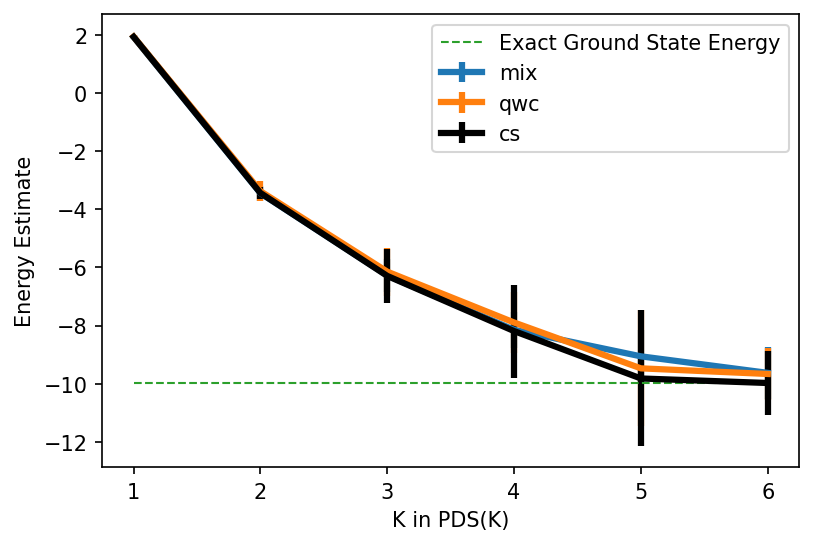

In [35]:
plt.errorbar(ks, [np.mean(data_no_outliers["mix_energy"][i]) for i in range(len(ks))], 
             yerr=[np.std(data_no_outliers["mix_energy"][i]) for i in range(len(ks))], lw =3, label="mix")
plt.errorbar(ks, [np.mean(data_no_outliers["qwc_energy"][i]) for i in range(len(ks))], 
             yerr=[np.std(data_no_outliers["qwc_energy"][i]) for i in range(len(ks))], lw =3, label="qwc")
plt.errorbar(ks, [np.mean(data_no_outliers["cs_energy"][i]) for i in range(len(ks))], 
             yerr=[np.std(data_no_outliers["cs_energy"][i]) for i in range(len(ks))], lw = 3, color="black", label="cs")
min_e = np.min(np.linalg.eigh(ham_mat)[0])
plt.plot(ks,[min_e]*len(ks),lw = 1, linestyle="dashed", label="Exact Ground State Energy")
plt.legend()
plt.xlabel("K in PDS(K)")
plt.ylabel("Energy Estimate")
plt.savefig("figures/energy_"+system+".jpg")

Looks pretty good! A prettier version of the plot will follow.

(471715.2, 0)


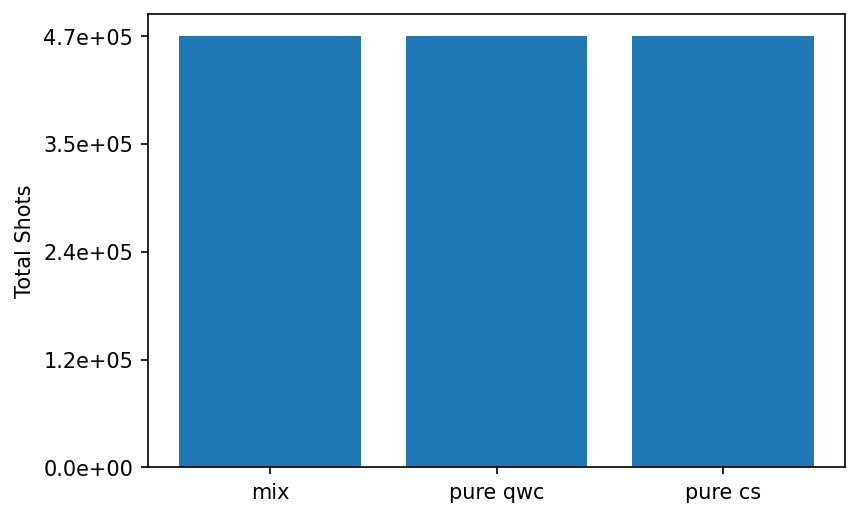

In [36]:
plt.bar(["mix","pure qwc","pure cs"],[data["mix_shots"].mean(), data["qwc_shots"].mean(), data["cs_shots"].mean()])
def get_ticks_shots(data_, p=35, n_ticks=5):
    # helper function to scale y-axis nicely
    max_ = -1000
    d1 = [np.mean(data_["mix_shots"][i]) for i in range(len(ks))] 
    d2 = [np.mean(data_["qwc_shots"][i]) for i in range(len(ks))]
    d3 = [np.mean(data_["cs_shots"][i]) for i in range(len(ks))] 
    max_ = max(max(d1), max(d2), max(d3))
    min_ = min(min(d1), min(d2), min(d3))
    bounds = (max_ + (0.01 * p) * (max_-min_), 0)
    print(bounds)
    ticks = np.linspace(bounds[0], bounds[1], n_ticks+2)
    return ticks
import matplotlib.ticker as mtick
plt.gca().yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))

sticks = get_ticks_shots(data,20,3)
plt.yticks(sticks)
plt.ylabel("Total Shots")
plt.savefig("figures/shots_"+system+".jpg")

**Set up analytical version of the system to calculate exact PDS(K) for comparison to moment mixing scheme**

In [37]:
n_qubits = 6
K = 6
ket0 = np.array([1.,0.],dtype=complex)
ket1 = np.array([0.,1.],dtype=complex)


PauliX = np.array([[0.,1.],[1.,0]], dtype=complex)
PauliY = np.array([[0.,-1.j],[1.j,0]], dtype=complex)
PauliZ = np.array([[1.0,0.],[0.,-1.]], dtype=complex)
PauliI = np.eye(2, dtype=complex)
PauliVec = [PauliX, PauliY, PauliZ]
cz = np.eye(4)
cz[3,3] = -1
PauliDict = {"Identity": "I", "PauliX": "X", "PauliY": "Y", "PauliZ": "Z"}
PauliNumToLetter = {0: "X", 1: "Y", 2: "Z"}
PauliDict_2 = {"I": PauliI, "X": PauliX, "Y": PauliY, "Z": PauliZ}
Hadamard = (1/np.sqrt(2)) * np.array([[1,1],[1,-1]])
CNOT = np.eye(4)
CNOT[3,3]=0
CNOT[2,2] = 0 
CNOT[3,2] = 1
CNOT[2,3] = 1
thetaTest = [-2,1]
cz = np.eye(4)
cz[3,3] = -1


"""

====================
FUNCTION DEFINITIONS
++++++++++++++++++++


"""

def RY(theta):
    '''
        matrix representation of the RY gate in the Z computational basis
    '''
    matrix = np.zeros((2,2),dtype=complex)
    matrix[0,0] = np.cos(theta/2)
    matrix[1,1] = np.cos(theta/2)
    matrix[0,1] = -np.sin(theta/2)
    matrix[1,0] =  np.sin(theta/2)
    return matrix
def RZ(theta):
    matrix = np.zeros((2,2), dtype=complex)
    matrix[0,0] = np.exp(-1.j * theta/2)
    matrix[1,1] = np.exp(1.j * theta/2)
    return matrix
def linear_hamiltonian_matrix_dict(j,u,b=1.0,n=10):
    '''
        represent our Hamiltonian as a matrix
    '''
    combos = list(combinations([int(i) for i in range(n)],2))
    H = {}
    for i in range(n-1):
        next_ = i+1

        for k in range(3):
            A = ["I" for i in range(n)]
            A[i] = PauliNumToLetter[k]
            A[next_] = PauliNumToLetter[k]
            x = j
            if(k==2):
                x = u
            H["".join(A)] = x
    return H

def linear_hamiltonian_matrix(j,u,b=1.0,n=10):
    '''
        represent our Hamiltonian as a matrix
    '''
    combos = list(combinations([int(i) for i in range(n)],2))
    H = np.zeros((2**n, 2**n), dtype=complex)
    for i in range(n-1):
        next_ = i+1

        for k in range(3):
            A = [PauliI for i in range(n)]
            A[i] = PauliVec[k]
            A[next_] = PauliVec[k]
            x = j
            if(k==2):
                x = u
            add = [1]
            for qbit in range(n):
                
                add = np.kron(add, A[qbit])
            H += x*add
    return H

def circuit(theta):
    qc = qm.QuantumCircuit(n_qubits,n_qubits)
    for w in range(n_qubits-1):
        qc.h(w)
        qc.ry(theta[w], w)
    for w in range(n_qubits-1):
        qc.cnot(w, w+1)
    for w in range(n_qubits):
        qc.rz(theta[w + n_qubits], w)
    return qc

def circuit_numerical(theta):
    psi = np.zeros(2 ** n_qubits)
    print(2**n_qubits)
    psi[0] = 1 # initialize in |0000....000>
    for w in range(n_qubits-1):
        obs_ = [1]
        for i in range(n_qubits):
            if not i == w:
                obs_ = np.kron(obs_, PauliI)
            else:
                obs_ = np.kron(obs_, Hadamard)
        psi = obs_ @ psi 
        obs_ = [1]
        for i in range(n_qubits):
            if not i == w:
                obs_ = np.kron(obs_, PauliI)
            else:
                obs_ = np.kron(obs_, RY(theta[w]))
        psi = obs_ @ psi 
    for w in range(n_qubits-1):
        obs_ = [1]
        for i in range(n_qubits):
            if not i == w and not i == w+1:
                obs_ = np.kron(obs_, PauliI)
            elif i == w:
                obs_ = np.kron(obs_, CNOT)
            elif i == w+1:
                pass;
            
        psi = obs_ @ psi
    for w in range(n_qubits):
        obs_ = [1]
        for i in range(n_qubits):
            if not i == w:
                obs_ = np.kron(obs_, PauliI)
            else:
                obs_ = np.kron(obs_, RZ(theta[w+n_qubits]))
        psi = obs_ @ psi
    return psi



def tildeM(e_dict, K):
    M = np.zeros((K,K), dtype=complex)
    for i in range(1,K+1):
        for j in range(1,K+1):
            M[i-1,j-1] = e_dict[int(2*K-i-j)]
    return M

def tildeY(e_dict, K):
    Y = np.zeros(K, dtype=complex)
    for i in range(1,K+1):
        Y[i-1] = e_dict[int(2*K-i)]
    return Y
def comp_energy(moments, K):
    M_ = tildeM(moments, K)
    Y_ = tildeY(moments, K)
    X_ = np.linalg.lstsq(M_, -Y_,rcond=None)[0]
    coeffs = np.ones(K+1)
    for k in range(1,K+1):
        coeffs[k] = X_[k-1].real
    return np.min(np.roots(coeffs)).real

In [38]:
theta_test = np.genfromtxt(keys[0]+"/theta_6_save.txt") # load the rotation used to prepare the ansatz
                                                        # all rotations for each run is are the same
                                                        # here we use the first run, however it shouldn't matter
psi_numerical = circuit_numerical(theta_test)

64


In [39]:

def lettersToNums(l):
    # some simple helper func to convert the pauli strings
    # into the form that the shadows use
    numsL = []
    for i in l:
        if(i == "X"):
            numsL += [0]
        elif(i == "Y"):
            numsL += [1]
        elif(i == "Z"):
            numsL += [2]
        else:
            numsL += [3]
    return numsL


In [40]:
def estimate_shadow_observable_fast(shadow, target_obs, k=10):
    '''Estimate the expectation value of an observabley,
    with k median of means chunks'''
    means = []
    snap, obs = shadow
    chunk_size = len(snap) // k
    pauli_locations = [i for i in range(len(target_obs)) if target_obs[i] != 3]
    tobs = target_obs[pauli_locations]
    snap2 = snap[:,pauli_locations]
    obs2 = obs[:,pauli_locations]
    nper = int(np.floor(len(obs) / k))
    num_per_max = [nper] * k
    num_per_max[-1] = len(snap) - nper * (k - 1)
    for i in range(k):
        snap_chunk, obs_chunk = (
            snap2[i * nper : i *nper + num_per_max[i]],
            obs2[i * nper : i *nper + num_per_max[i]],
        )
        indices = np.all(obs_chunk == tobs, axis=1)
        if sum(indices) > 0:
            means += [np.sum(np.prod(snap_chunk[indices], axis=1))/sum(indices)]
        else:
            means += [0]
    return np.median(means)

In [41]:
moments = {i: np.conjugate(psi_numerical).T @ np.linalg.matrix_power(ham_qm.to_matrix(), i) @ psi_numerical for i in range(0,15)}

In [42]:
print("Exact Moments:")
print(moments)

Exact Moments:
{0: (0.9999999999999994+0j), 1: (2.180241230752084-2.7755575615628914e-17j), 2: (12.851391526150788+6.661338147750939e-16j), 3: (30.047214120883048-1.3322676295501878e-15j), 4: (259.1784588960356+0j), 5: (195.40706610624065+4.263256414560601e-14j), 6: (8064.775356786946+4.547473508864641e-13j), 7: (-23036.254312159414-1.8189894035458565e-12j), 8: (413126.00104851107+7.275957614183426e-12j), 9: (-2744686.7980179037-4.0745362639427185e-10j), 10: (30056164.002566908+0j), 11: (-259429663.83229798-3.725290298461914e-09j), 12: (2567714525.1830664-1.7881393432617188e-07j), 13: (-24067191229.929848-4.291534423828125e-06j), 14: (234569228381.20563-2.288818359375e-05j)}


In [43]:
def moment(n, e_dict_, ham_):
    e = 0
    for i in range(len(ham_.letters)):
        e += ham_.coeffs[i] * e_dict_[ham_.letters[i]]
    return e

In [44]:
ks = [i for i in range(1, K+1)]
es = []
for k in ks:
    es += [comp_energy(moments, k)]

In [45]:
exact_pds = es
print(exact_pds)

[2.1802412307520855, -3.3849124302490248, -6.248161722714698, -8.343676501476288, -9.338884240947579, -9.674584401762555]


**Calculate errors for moment mix runs**

In [46]:
errors = {}
errors["mix_energy"] = [0]*len(ks)
errors["cs_energy"] = [0]*len(ks)
errors["qwc_energy"] = [0]*len(ks)
for j in range(len(ks)):
    errors["mix_energy"][j] = np.abs(np.array(data_no_outliers["mix_energy"][j])-exact_pds[j])
    errors["cs_energy"][j] = np.abs(np.array(data_no_outliers["cs_energy"][j])-exact_pds[j])
    errors["qwc_energy"][j] = np.abs(np.array(data_no_outliers["qwc_energy"][j])-exact_pds[j])


In [47]:
def get_ticks(data_, p=35, n_ticks=5):
    max_ = -1000
    d1 = [np.mean(data_["mix_energy"][i]) for i in range(len(ks))] 
    d2 = [np.mean(data_["qwc_energy"][i]) for i in range(len(ks))]
    d3 = [np.mean(data_["cs_energy"][i]) for i in range(len(ks))] 
    max_ = max(max(d1), max(d2), max(d3))
    min_ = min(min(d1), min(d2), min(d3))
    bounds = (max_ + (0.01 * p) * (max_-min_), min_ - (0.01 * p) * (max_-min_))
    print(bounds)
    ticks = np.linspace(bounds[0], bounds[1], n_ticks+2)
    return ticks

In [48]:
ticks = get_ticks(data_no_outliers)
eticks = get_ticks(errors, 130)
print(eticks)

(6.101145232226778, -14.144778973694901)
(2.644239104973857, -1.2253004018951068)
[ 2.6442391   1.99931585  1.3543926   0.70946935  0.0645461  -0.58037715
 -1.2253004 ]


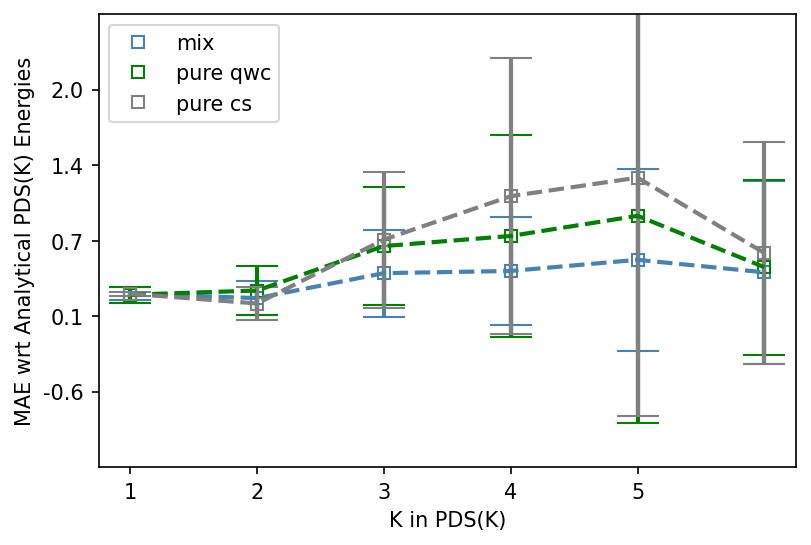

In [49]:
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import StrMethodFormatter
fig, ax1 = plt.subplots()
ax1.errorbar(ks, [np.mean(np.abs(errors["mix_energy"][i])) for i in range(len(ks))],
             yerr=[np.std(np.abs(errors["mix_energy"][i])) for i in range(len(ks))],
             capsize=10,lw =2,ls="dashed", color=colors[0])
ax1.plot(ks, [np.mean(np.abs(errors["mix_energy"][i])) for i in range(len(ks))],
          marker='s', color=colors[0],linestyle="none",fillstyle='none',label="mix")
ax1.errorbar(ks, [np.mean(np.abs(errors["qwc_energy"][i])) for i in range(len(ks))],
             yerr=[np.std(np.abs(errors["qwc_energy"][i])) for i in range(len(ks))],
             capsize=10,lw =2,ls="dashed", color=colors[1])
ax1.plot(ks, [np.mean(np.abs(errors["qwc_energy"][i])) for i in range(len(ks))],
          marker='s', color=colors[1],linestyle="none",fillstyle='none',label="pure qwc")
ax1.errorbar(ks, [np.mean(np.abs(errors["cs_energy"][i])) for i in range(len(ks))],
             yerr=[np.std(np.abs(errors["cs_energy"][i])) for i in range(len(ks))],
             capsize=10,lw =2,ls="dashed", color=colors[2])
ax1.plot(ks, [np.mean(np.abs(errors["cs_energy"][i])) for i in range(len(ks))],
          marker='s', color=colors[2],linestyle="none",fillstyle='none',label="pure cs")
ax1.set_xticks([1,2,3,4,5])
ax1.set_yticks(eticks[1:-1])
ax1.set_ylim((eticks[-1], eticks[0]))
ax1.legend(loc="upper left")
ax1.set_ylabel("MAE wrt Analytical PDS(K) Energies")
ax1.set_xlabel("K in PDS(K)")
ax1.yaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}')) # 2 decimal places
plt.savefig("figures/mae_pretty_"+system+".jpg")

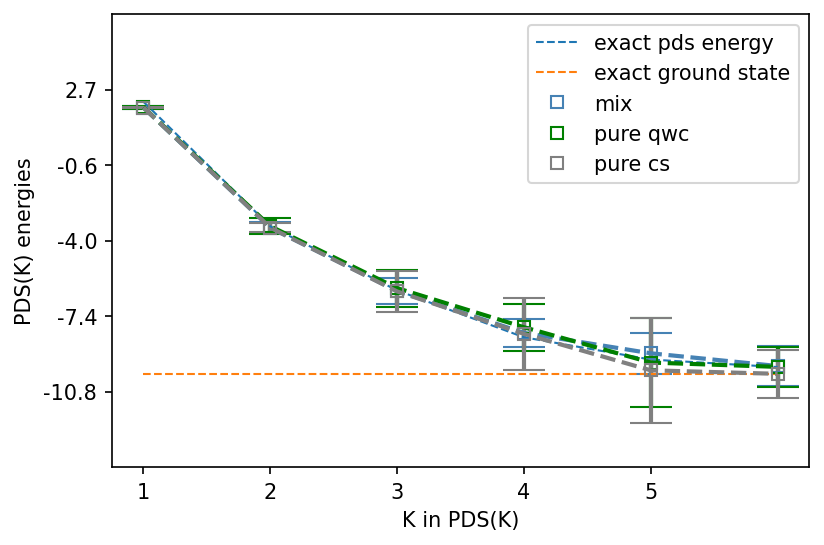

In [50]:
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import StrMethodFormatter

plt.errorbar(ks, [np.mean(data_no_outliers["mix_energy"][i]) for i in range(len(ks))], 
             yerr=[np.std(data_no_outliers["mix_energy"][i]) for i in range(len(ks))], lw =2, ls="dashed", capsize=10, color=colors[0])
plt.errorbar(ks, [np.mean(data_no_outliers["mix_energy"][i]) for i in range(len(ks))], marker="s", fillstyle="none",ls="none",label="mix", color=colors[0])
plt.errorbar(ks, [np.mean(data_no_outliers["qwc_energy"][i]) for i in range(len(ks))], 
             yerr=[np.std(data_no_outliers["qwc_energy"][i]) for i in range(len(ks))], lw =2, ls="dashed", capsize=10, color=colors[1])
plt.errorbar(ks, [np.mean(data_no_outliers["qwc_energy"][i]) for i in range(len(ks))], marker="s", fillstyle="none",ls="none",label="pure qwc", color=colors[1])
plt.errorbar(ks, [np.mean(data_no_outliers["cs_energy"][i]) for i in range(len(ks))], 
             yerr=[np.std(data_no_outliers["cs_energy"][i]) for i in range(len(ks))], lw =2, ls="dashed", capsize=10, color=colors[2])
plt.errorbar(ks, [np.mean(data_no_outliers["cs_energy"][i]) for i in range(len(ks))], marker="s", fillstyle="none",ls="none",label="pure cs", color=colors[2])
plt.plot(ks,exact_pds,lw = 1, linestyle="dashed", label="exact pds energy")
plt.plot(ks,[min_e]*len(ks),lw = 1, linestyle="dashed", label="exact ground state")
plt.legend()
plt.xticks([1,2,3,4,5])
plt.ylim((ticks[-1], ticks[0]))
plt.xlabel("K in PDS(K)")
plt.ylabel("PDS(K) energies")
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}')) # 2 decimal places
plt.yticks(ticks[1:-1])
min_e = np.min(np.linalg.eigh(ham_mat)[0])
plt.savefig("figures/energy_pretty_"+system+".jpg")

** some extra code to analyze the moment estimations for each method

[0, 2.220446049250313e-16, (1+0j), (1+0j)]


/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/numpy/ma/core.py:3379: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


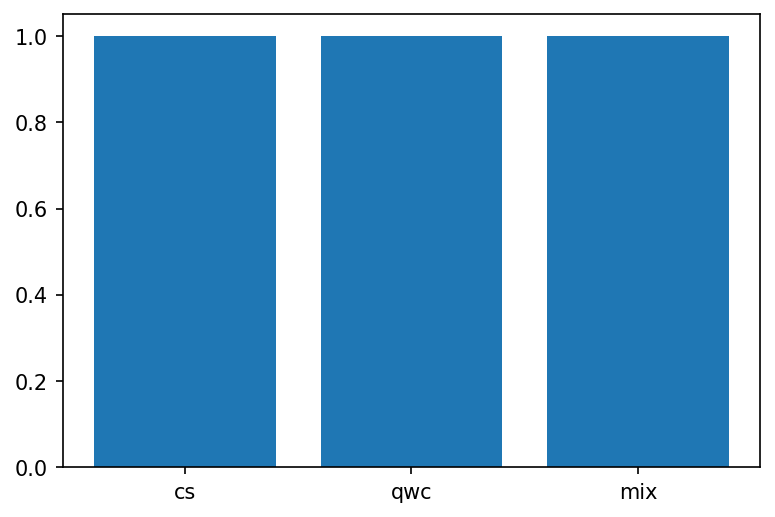

/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/numpy/ma/core.py:3379: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


[1, 0.019075394367002514, (1.932866719242902+0j), (1.922793820270161+0j)]


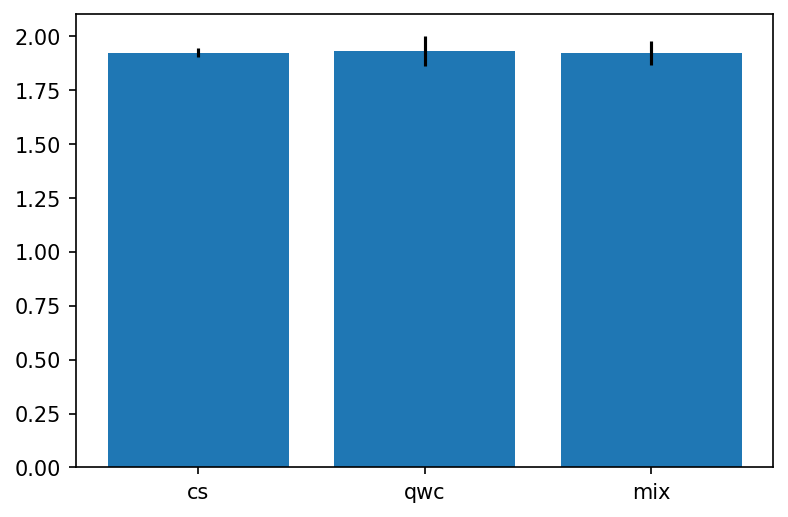

[2, 0.2200609300232734, (12.685316064062121+0j), (12.755722721022407+0j)]


/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/numpy/ma/core.py:3379: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


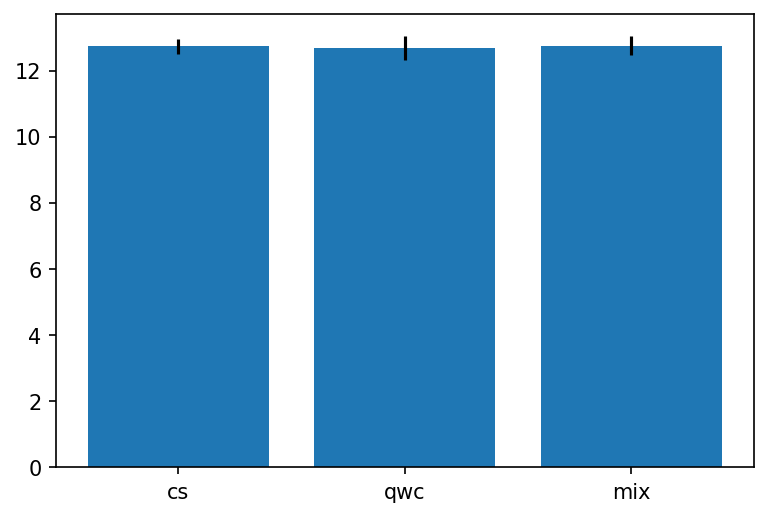

[3, 2.0678609857161603, (26.4287566731376+0j), (25.856112998463164+0j)]


/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/numpy/ma/core.py:3379: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


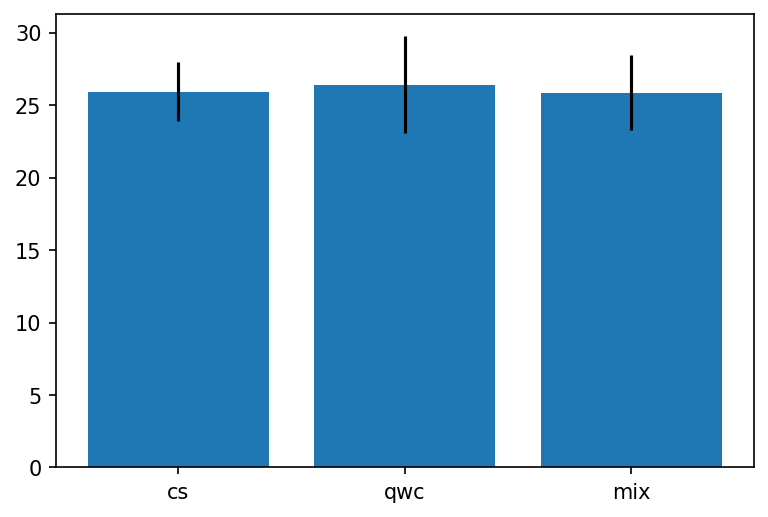

[4, 22.533515932049397, (268.2675624848338+0j), (272.0849712852868+0j)]


/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/numpy/ma/core.py:3379: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


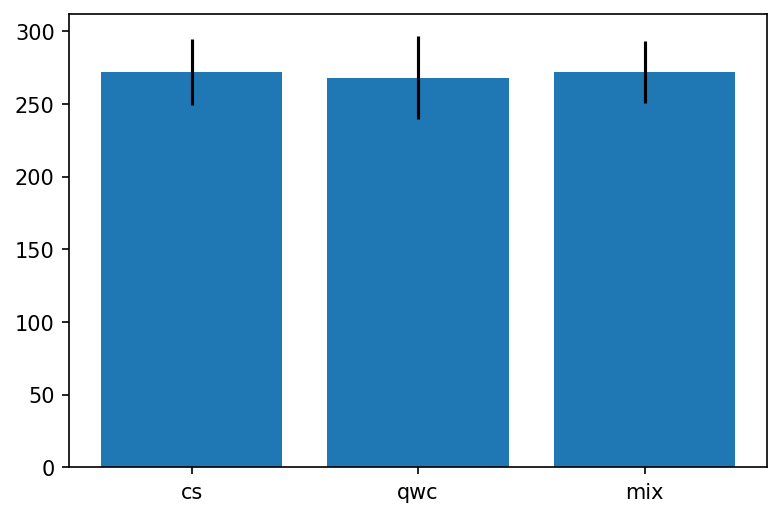

[5, 252.49012378120602, (93.23616082261594+0j), (61.45925839815211+0j)]


/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/numpy/ma/core.py:3379: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


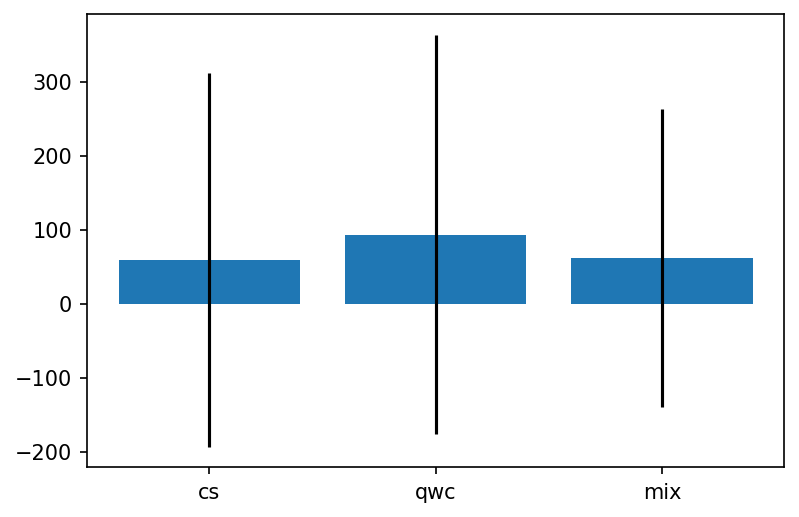

/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/numpy/ma/core.py:3379: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


[6, 2678.573201702725, (8839.683405120119+0j), (9074.977295349696+0j)]


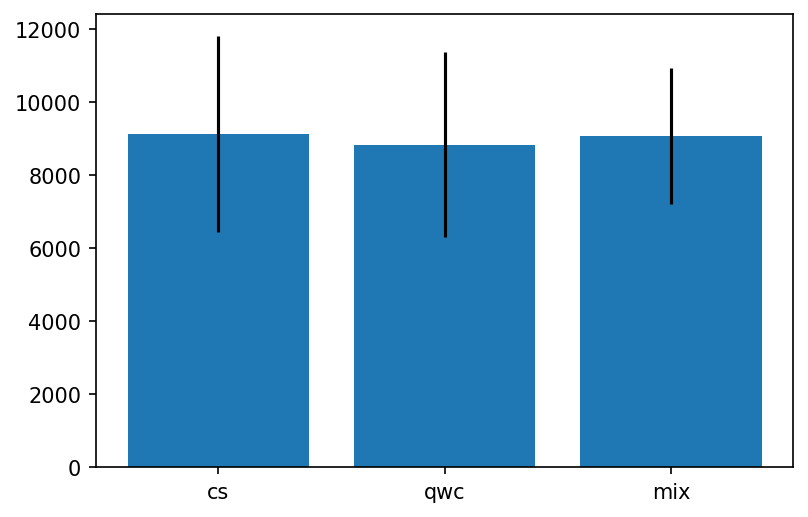

/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/numpy/ma/core.py:3379: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


[7, 28426.449396652795, (-28353.24380459838+0j), (-30381.141229334917+0j)]


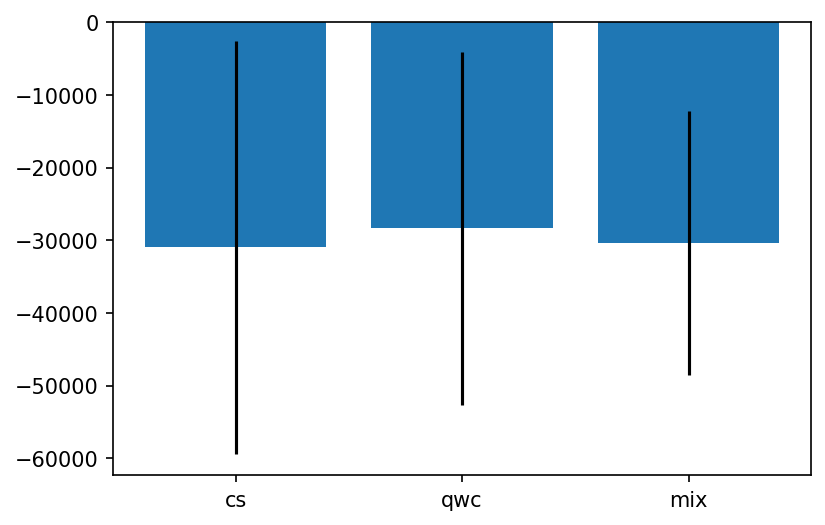

/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/numpy/ma/core.py:3379: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


[8, 295302.0188493938, (458179.3635646688+0j), (474916.0173664722+0j)]


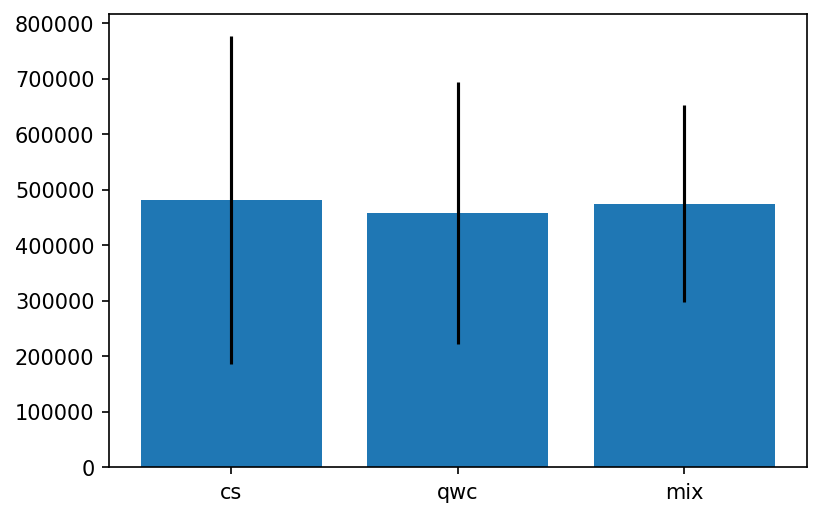

[9, 3051417.6365735624, (-3036778.799783122+0j), (-3186244.268947843+0j)]


/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/numpy/ma/core.py:3379: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


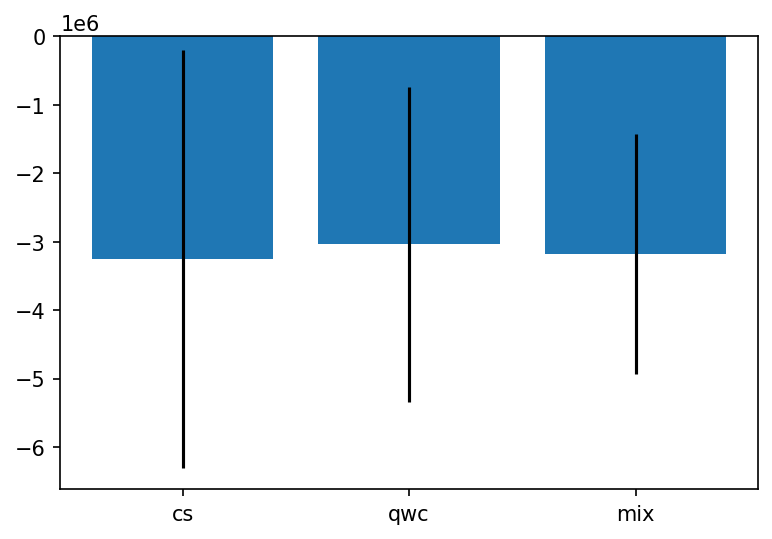

[10, 31247395.019688454, (32291853.746041603+0j), (33618524.26641451+0j)]


/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/numpy/ma/core.py:3379: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


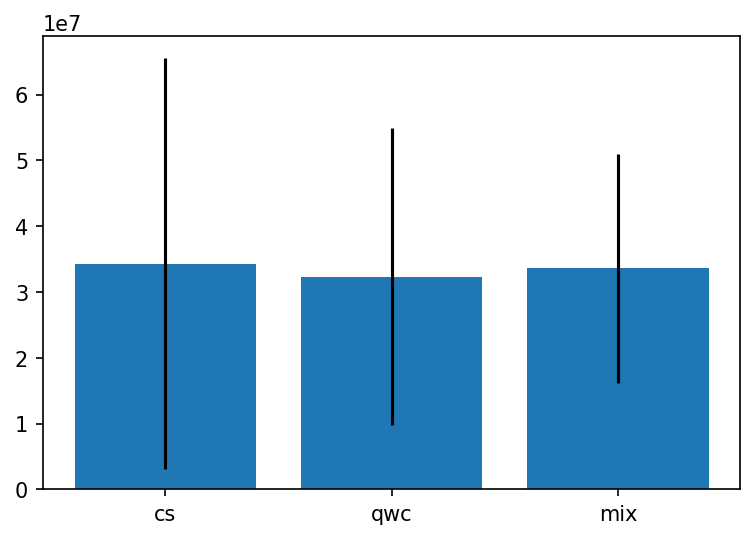

/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


[11, 318508224.86497676, (-272747553.03308487+0j), (-284972404.7963263+0j)]


/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/numpy/ma/core.py:3379: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


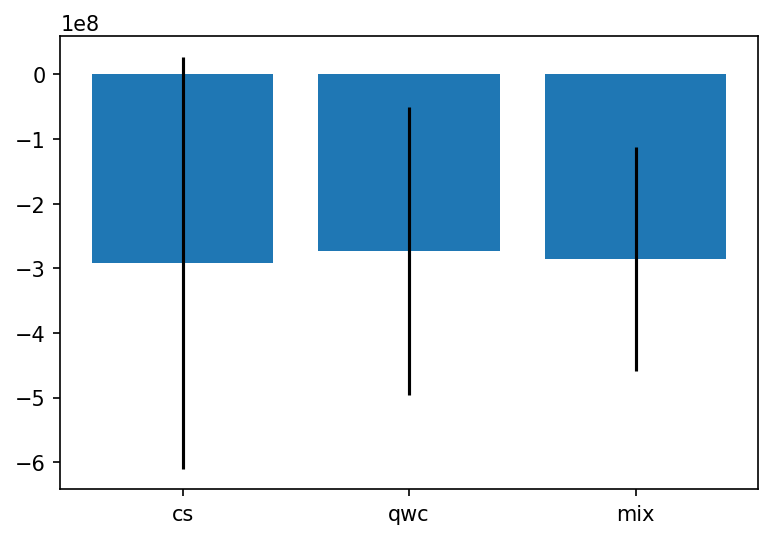

[ 1.00000000e+00+0.j  1.90581747e+00+0.j  1.29174191e+01+0.j
  2.43615225e+01+0.j  2.89392807e+02+0.j -9.20375788e+01+0.j
  1.06382756e+04+0.j -4.47397402e+04+0.j  6.13628762e+05+0.j
 -4.48847656e+06+0.j  4.60898760e+07+0.j -4.03939818e+08+0.j]
[ 1.00000000e+00+0.j  1.93339100e+00+0.j  1.27009981e+01+0.j
  2.50231442e+01+0.j  2.81385571e+02+0.j -4.48958178e+01+0.j
  1.00147983e+04+0.j -3.87260716e+04+0.j  5.44687552e+05+0.j
 -3.76926764e+06+0.j  3.84005625e+07+0.j -3.24193474e+08+0.j]
[ 1.00000000e+00+0.j  1.90828547e+00+0.j  1.27973776e+01+0.j
  2.51113970e+01+0.j  2.79711698e+02+0.j -1.04006169e+01+0.j
  9.92958736e+03+0.j -3.91839524e+04+0.j  5.71777931e+05+0.j
 -4.19629302e+06+0.j  4.42516825e+07+0.j -3.94699278e+08+0.j]
[ 1.00000000e+00+0.j  1.90862386e+00+0.j  1.30221476e+01+0.j
  2.55615276e+01+0.j  2.72055067e+02+0.j  1.74091897e+02+0.j
  7.48484487e+03+0.j -8.60773094e+03+0.j  2.20973225e+05+0.j
 -3.05807980e+05+0.j  2.35700419e+06+0.j  4.84138674e+07+0.j]
[ 1.00000000e+00+0.j

/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/numpy/ma/core.py:3379: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


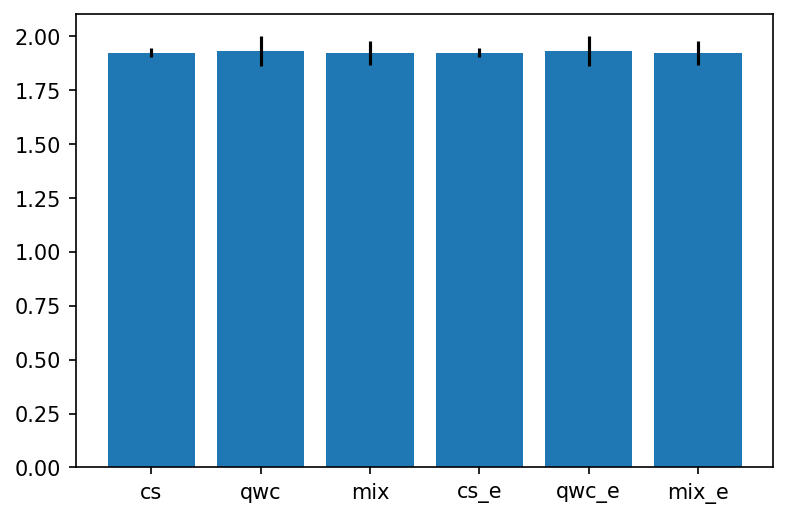

[ 1.00000000e+00+0.j  1.90581747e+00+0.j  1.29174191e+01+0.j
  2.43615225e+01+0.j  2.89392807e+02+0.j -9.20375788e+01+0.j
  1.06382756e+04+0.j -4.47397402e+04+0.j  6.13628762e+05+0.j
 -4.48847656e+06+0.j  4.60898760e+07+0.j -4.03939818e+08+0.j]
[ 1.00000000e+00+0.j  1.93339100e+00+0.j  1.27009981e+01+0.j
  2.50231442e+01+0.j  2.81385571e+02+0.j -4.48958178e+01+0.j
  1.00147983e+04+0.j -3.87260716e+04+0.j  5.44687552e+05+0.j
 -3.76926764e+06+0.j  3.84005625e+07+0.j -3.24193474e+08+0.j]
[ 1.00000000e+00+0.j  1.90828547e+00+0.j  1.27973776e+01+0.j
  2.51113970e+01+0.j  2.79711698e+02+0.j -1.04006169e+01+0.j
  9.92958736e+03+0.j -3.91839524e+04+0.j  5.71777931e+05+0.j
 -4.19629302e+06+0.j  4.42516825e+07+0.j -3.94699278e+08+0.j]
[ 1.00000000e+00+0.j  1.90862386e+00+0.j  1.30221476e+01+0.j
  2.55615276e+01+0.j  2.72055067e+02+0.j  1.74091897e+02+0.j
  7.48484487e+03+0.j -8.60773094e+03+0.j  2.20973225e+05+0.j
 -3.05807980e+05+0.j  2.35700419e+06+0.j  4.84138674e+07+0.j]
[ 1.00000000e+00+0.j

 -1.13800086e+06+0.j  1.19200839e+07+0.j -5.85492861e+07+0.j]
[ 1.00000000e+00+0.j  1.94674755e+00+0.j  1.26863080e+01+0.j
  2.55348553e+01+0.j  2.82362577e+02+0.j -8.13501582e+01+0.j
  1.07270320e+04+0.j -4.79578409e+04+0.j  6.55122657e+05+0.j
 -4.99641115e+06+0.j  5.16303977e+07+0.j -4.63405767e+08+0.j]
[ 1.00000000e+00+0.j  1.92236159e+00+0.j  1.27155953e+01+0.j
  2.51236414e+01+0.j  2.77973680e+02+0.j -4.97444601e+01+0.j
  1.00087049e+04+0.j -4.06333455e+04+0.j  5.64014721e+05+0.j
 -4.03929804e+06+0.j  4.12137619e+07+0.j -3.55275806e+08+0.j]
[ 1.00000000e+00+0.j  1.93371540e+00+0.j  1.29168662e+01+0.j
  2.21497926e+01+0.j  3.15326017e+02+0.j -4.39833790e+02+0.j
  1.42151959e+04+0.j -8.39527063e+04+0.j  1.01535761e+06+0.j
 -8.66688073e+06+0.j  8.86728964e+07+0.j -8.38406570e+08+0.j]
[ 1.00000000e+00+0.j  1.94055012e+00+0.j  1.26347377e+01+0.j
  2.77839693e+01+0.j  2.51840048e+02+0.j  3.05678718e+02+0.j
  6.43171316e+03+0.j -1.90074723e+03+0.j  1.76752936e+05+0.j
 -9.72249692e+04+0.j

/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/numpy/ma/core.py:3379: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


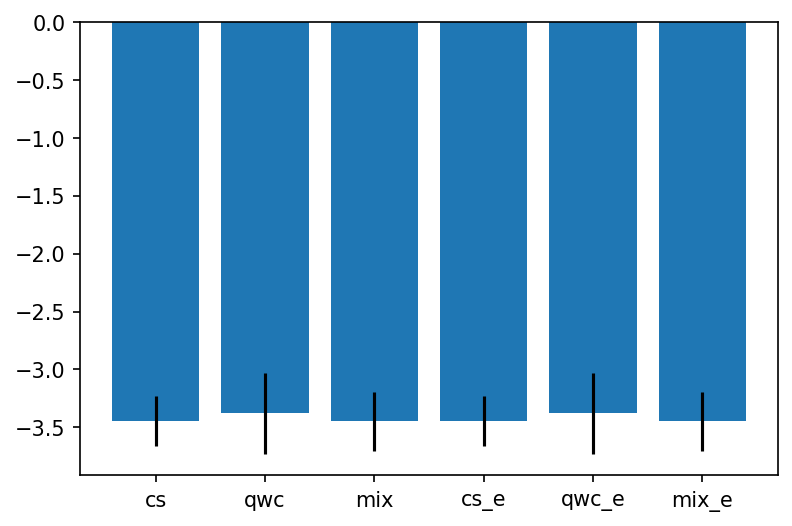

[ 1.00000000e+00+0.j  1.90581747e+00+0.j  1.29174191e+01+0.j
  2.43615225e+01+0.j  2.89392807e+02+0.j -9.20375788e+01+0.j
  1.06382756e+04+0.j -4.47397402e+04+0.j  6.13628762e+05+0.j
 -4.48847656e+06+0.j  4.60898760e+07+0.j -4.03939818e+08+0.j]
[ 1.00000000e+00+0.j  1.93339100e+00+0.j  1.27009981e+01+0.j
  2.50231442e+01+0.j  2.81385571e+02+0.j -4.48958178e+01+0.j
  1.00147983e+04+0.j -3.87260716e+04+0.j  5.44687552e+05+0.j
 -3.76926764e+06+0.j  3.84005625e+07+0.j -3.24193474e+08+0.j]
[ 1.00000000e+00+0.j  1.90828547e+00+0.j  1.27973776e+01+0.j
  2.51113970e+01+0.j  2.79711698e+02+0.j -1.04006169e+01+0.j
  9.92958736e+03+0.j -3.91839524e+04+0.j  5.71777931e+05+0.j
 -4.19629302e+06+0.j  4.42516825e+07+0.j -3.94699278e+08+0.j]
[ 1.00000000e+00+0.j  1.90862386e+00+0.j  1.30221476e+01+0.j
  2.55615276e+01+0.j  2.72055067e+02+0.j  1.74091897e+02+0.j
  7.48484487e+03+0.j -8.60773094e+03+0.j  2.20973225e+05+0.j
 -3.05807980e+05+0.j  2.35700419e+06+0.j  4.84138674e+07+0.j]
[ 1.00000000e+00+0.j

 -1.69881451e+06+0.j  1.87065385e+07+0.j -1.35006641e+08+0.j]
[ 1.00000000e+00+0.j  1.93176903e+00+0.j  1.25936040e+01+0.j
  2.88108211e+01+0.j  2.39979595e+02+0.j  4.11767360e+02+0.j
  5.54070878e+03+0.j  5.32288013e+03+0.j  1.20804773e+05+0.j
  3.30779887e+05+0.j -1.17186877e+06+0.j  5.96698438e+07+0.j]
[ 1.00000000e+00+0.j  1.93047145e+00+0.j  1.27642891e+01+0.j
  2.80654863e+01+0.j  2.53090377e+02+0.j  2.86537605e+02+0.j
  6.97375091e+03+0.j -9.49335224e+03+0.j  2.76651103e+05+0.j
 -1.26968969e+06+0.j  1.52245541e+07+0.j -1.06941669e+08+0.j]
[ 1.00000000e+00+0.j  1.93182488e+00+0.j  1.25381508e+01+0.j
  2.56702153e+01+0.j  2.70476242e+02+0.j  5.94729700e+00+0.j
  9.62206069e+03+0.j -3.80873789e+04+0.j  5.56453843e+05+0.j
 -4.08716909e+06+0.j  4.30027302e+07+0.j -3.82843209e+08+0.j]


/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/numpy/ma/core.py:3379: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


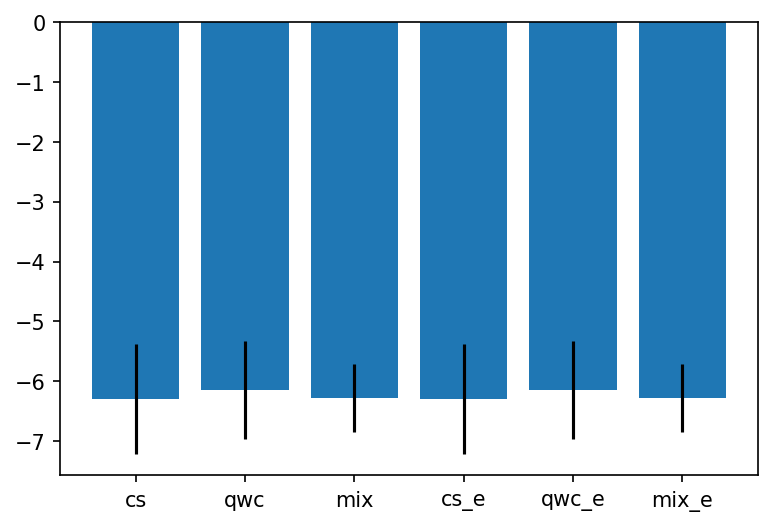

[ 1.00000000e+00+0.j  1.90581747e+00+0.j  1.29174191e+01+0.j
  2.43615225e+01+0.j  2.89392807e+02+0.j -9.20375788e+01+0.j
  1.06382756e+04+0.j -4.47397402e+04+0.j  6.13628762e+05+0.j
 -4.48847656e+06+0.j  4.60898760e+07+0.j -4.03939818e+08+0.j]
[ 1.00000000e+00+0.j  1.93339100e+00+0.j  1.27009981e+01+0.j
  2.50231442e+01+0.j  2.81385571e+02+0.j -4.48958178e+01+0.j
  1.00147983e+04+0.j -3.87260716e+04+0.j  5.44687552e+05+0.j
 -3.76926764e+06+0.j  3.84005625e+07+0.j -3.24193474e+08+0.j]
[ 1.00000000e+00+0.j  1.90828547e+00+0.j  1.27973776e+01+0.j
  2.51113970e+01+0.j  2.79711698e+02+0.j -1.04006169e+01+0.j
  9.92958736e+03+0.j -3.91839524e+04+0.j  5.71777931e+05+0.j
 -4.19629302e+06+0.j  4.42516825e+07+0.j -3.94699278e+08+0.j]
[ 1.00000000e+00+0.j  1.90862386e+00+0.j  1.30221476e+01+0.j
  2.55615276e+01+0.j  2.72055067e+02+0.j  1.74091897e+02+0.j
  7.48484487e+03+0.j -8.60773094e+03+0.j  2.20973225e+05+0.j
 -3.05807980e+05+0.j  2.35700419e+06+0.j  4.84138674e+07+0.j]
[ 1.00000000e+00+0.j

 -9.72249692e+04+0.j  1.94615252e+06+0.j  3.77081050e+07+0.j]
[ 1.00000000e+00+0.j  1.90914549e+00+0.j  1.24699546e+01+0.j
  2.57518257e+01+0.j  2.66730214e+02+0.j  8.37485099e+00+0.j
  9.55517770e+03+0.j -3.84689447e+04+0.j  5.58959702e+05+0.j
 -4.13583080e+06+0.j  4.34094373e+07+0.j -3.87087087e+08+0.j]
[ 1.00000000e+00+0.j  1.92096908e+00+0.j  1.27390733e+01+0.j
  2.82529731e+01+0.j  2.47551109e+02+0.j  3.19002800e+02+0.j
  6.72994164e+03+0.j -9.16115394e+03+0.j  2.87924938e+05+0.j
 -1.53556741e+06+0.j  1.90664311e+07+0.j -1.55709239e+08+0.j]
[ 1.00000000e+00+0.j  1.94510184e+00+0.j  1.24963885e+01+0.j
  2.78352268e+01+0.j  2.54028958e+02+0.j  2.24556198e+02+0.j
  7.53220785e+03+0.j -1.53315355e+04+0.j  3.26296795e+05+0.j
 -1.69881451e+06+0.j  1.87065385e+07+0.j -1.35006641e+08+0.j]
[ 1.00000000e+00+0.j  1.93176903e+00+0.j  1.25936040e+01+0.j
  2.88108211e+01+0.j  2.39979595e+02+0.j  4.11767360e+02+0.j
  5.54070878e+03+0.j  5.32288013e+03+0.j  1.20804773e+05+0.j
  3.30779887e+05+0.j

/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/numpy/ma/core.py:3379: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


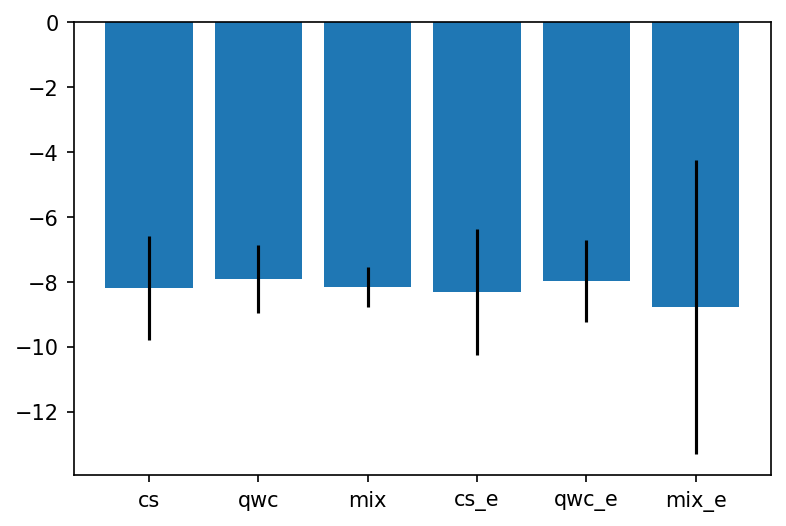

[ 1.00000000e+00+0.j  1.90581747e+00+0.j  1.29174191e+01+0.j
  2.43615225e+01+0.j  2.89392807e+02+0.j -9.20375788e+01+0.j
  1.06382756e+04+0.j -4.47397402e+04+0.j  6.13628762e+05+0.j
 -4.48847656e+06+0.j  4.60898760e+07+0.j -4.03939818e+08+0.j]
[ 1.00000000e+00+0.j  1.93339100e+00+0.j  1.27009981e+01+0.j
  2.50231442e+01+0.j  2.81385571e+02+0.j -4.48958178e+01+0.j
  1.00147983e+04+0.j -3.87260716e+04+0.j  5.44687552e+05+0.j
 -3.76926764e+06+0.j  3.84005625e+07+0.j -3.24193474e+08+0.j]
[ 1.00000000e+00+0.j  1.90828547e+00+0.j  1.27973776e+01+0.j
  2.51113970e+01+0.j  2.79711698e+02+0.j -1.04006169e+01+0.j
  9.92958736e+03+0.j -3.91839524e+04+0.j  5.71777931e+05+0.j
 -4.19629302e+06+0.j  4.42516825e+07+0.j -3.94699278e+08+0.j]
[ 1.00000000e+00+0.j  1.90862386e+00+0.j  1.30221476e+01+0.j
  2.55615276e+01+0.j  2.72055067e+02+0.j  1.74091897e+02+0.j
  7.48484487e+03+0.j -8.60773094e+03+0.j  2.20973225e+05+0.j
 -3.05807980e+05+0.j  2.35700419e+06+0.j  4.84138674e+07+0.j]
[ 1.00000000e+00+0.j

 -7.22332224e+06+0.j  7.43388023e+07+0.j -6.93871224e+08+0.j]
[ 1.00000000e+00+0.j  1.95253028e+00+0.j  1.29714662e+01+0.j
  2.46067014e+01+0.j  2.91561497e+02+0.j -1.01423491e+02+0.j
  1.08015172e+04+0.j -4.65753048e+04+0.j  6.36032728e+05+0.j
 -4.74978982e+06+0.j  4.90240029e+07+0.j -4.36197094e+08+0.j]
[ 1.00000000e+00+0.j  1.94096261e+00+0.j  1.26085417e+01+0.j
  2.36508845e+01+0.j  2.96531017e+02+0.j -3.04068970e+02+0.j
  1.29722950e+04+0.j -7.35522500e+04+0.j  9.24122562e+05+0.j
 -7.86285843e+06+0.j  8.15088375e+07+0.j -7.73523830e+08+0.j]
[ 1.00000000e+00+0.j  1.91323900e+00+0.j  1.27040202e+01+0.j
  2.57426715e+01+0.j  2.69803318e+02+0.j  5.54296114e+01+0.j
  9.31976439e+03+0.j -3.56122522e+04+0.j  5.51307245e+05+0.j
 -4.17710492e+06+0.j  4.54324133e+07+0.j -4.19279616e+08+0.j]
[ 1.00000000e+00+0.j  1.91911765e+00+0.j  1.33724571e+01+0.j
  2.31966657e+01+0.j  3.09733153e+02+0.j -1.93780522e+02+0.j
  1.16782763e+04+0.j -5.19039578e+04+0.j  6.78001308e+05+0.j
 -5.00518255e+06+0.j

/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/numpy/ma/core.py:3379: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


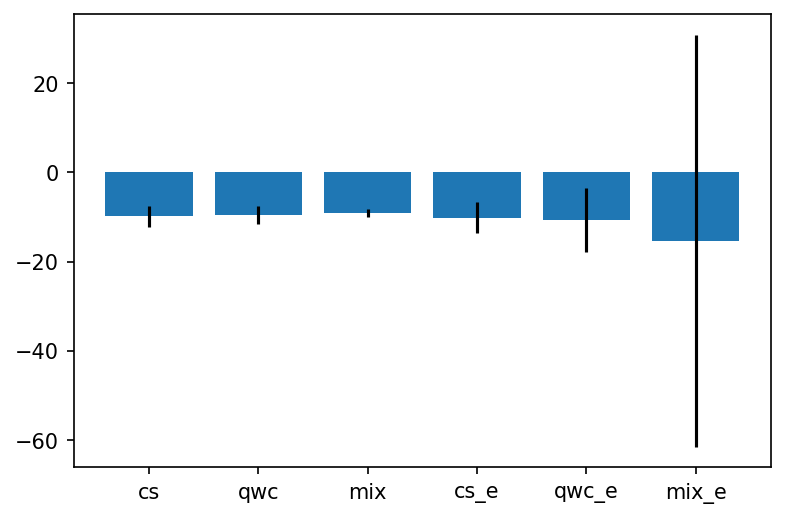

[ 1.00000000e+00+0.j  1.90581747e+00+0.j  1.29174191e+01+0.j
  2.43615225e+01+0.j  2.89392807e+02+0.j -9.20375788e+01+0.j
  1.06382756e+04+0.j -4.47397402e+04+0.j  6.13628762e+05+0.j
 -4.48847656e+06+0.j  4.60898760e+07+0.j -4.03939818e+08+0.j]
[ 1.00000000e+00+0.j  1.93339100e+00+0.j  1.27009981e+01+0.j
  2.50231442e+01+0.j  2.81385571e+02+0.j -4.48958178e+01+0.j
  1.00147983e+04+0.j -3.87260716e+04+0.j  5.44687552e+05+0.j
 -3.76926764e+06+0.j  3.84005625e+07+0.j -3.24193474e+08+0.j]
[ 1.00000000e+00+0.j  1.90828547e+00+0.j  1.27973776e+01+0.j
  2.51113970e+01+0.j  2.79711698e+02+0.j -1.04006169e+01+0.j
  9.92958736e+03+0.j -3.91839524e+04+0.j  5.71777931e+05+0.j
 -4.19629302e+06+0.j  4.42516825e+07+0.j -3.94699278e+08+0.j]
[ 1.00000000e+00+0.j  1.90862386e+00+0.j  1.30221476e+01+0.j
  2.55615276e+01+0.j  2.72055067e+02+0.j  1.74091897e+02+0.j
  7.48484487e+03+0.j -8.60773094e+03+0.j  2.20973225e+05+0.j
 -3.05807980e+05+0.j  2.35700419e+06+0.j  4.84138674e+07+0.j]
[ 1.00000000e+00+0.j

 -8.44483063e+06+0.j  8.71361704e+07+0.j -8.29243801e+08+0.j]
[ 1.00000000e+00+0.j  1.92030679e+00+0.j  1.26539792e+01+0.j
  2.48578683e+01+0.j  2.82193440e+02+0.j -1.09825799e+02+0.j
  1.08675356e+04+0.j -5.06568414e+04+0.j  6.82938400e+05+0.j
 -5.34881428e+06+0.j  5.55255879e+07+0.j -5.07133265e+08+0.j]
[ 1.00000000e+00+0.j  1.93500631e+00+0.j  1.28760467e+01+0.j
  2.38384989e+01+0.j  2.89064582e+02+0.j -6.53274133e+01+0.j
  9.91740886e+03+0.j -3.48685740e+04+0.j  4.88379763e+05+0.j
 -3.05334674e+06+0.j  3.01839050e+07+0.j -2.33326780e+08+0.j]
[ 1.00000000e+00+0.j  1.93889975e+00+0.j  1.27615392e+01+0.j
  2.68807372e+01+0.j  2.68781292e+02+0.j  1.15530498e+02+0.j
  8.74450232e+03+0.j -2.67726514e+04+0.j  4.45183189e+05+0.j
 -2.89075278e+06+0.j  3.08807651e+07+0.j -2.58142551e+08+0.j]
[ 1.00000000e+00+0.j  1.93922625e+00+0.j  1.24129087e+01+0.j
  3.20945563e+01+0.j  2.08208670e+02+0.j  7.81730491e+02+0.j
  1.82730944e+03+0.j  4.39736673e+04+0.j -2.68640672e+05+0.j
  4.27167758e+06+0.j

/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/numpy/ma/core.py:3379: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


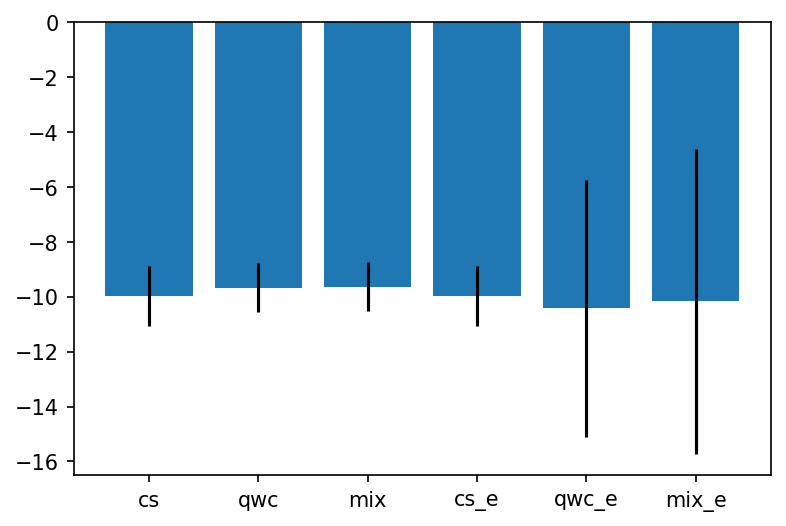

In [51]:
# moment data analysis
for i in range(2*K):
    cs_moments = [complex(s) for s in data["cs_moments"][i]]
    qwc_moments = [complex(s) for s in data["qwc_moments"][i]]
    mix_moments = [complex(s) for s in data["mix_moments"][i]]
    plt.bar(["cs","qwc","mix"],[np.mean(cs_moments), np.mean(qwc_moments), np.mean(mix_moments)], 
           yerr = [np.std(cs_moments), np.std(qwc_moments), np.std(mix_moments)])
    print([i, np.std(cs_moments), np.mean(qwc_moments), np.mean(mix_moments)])
    plt.show()
cs_moments = np.array([[complex(s) for s in data["cs_moments"][i]] for i in range(2*K)])
qwc_moments = np.array([[complex(s) for s in data["qwc_moments"][i]] for i in range(2*K)])
mix_moments = np.array([[complex(s) for s in data["mix_moments"][i]] for i in range(2*K)])
for i in range(6):
    cs_e = []
    qwc_e = []
    mix_e = []
    for n_ in range(n_points):
        print(cs_moments[:,n_])
        cs_e += [comp_energy(cs_moments[:,n_], i+1)]
        qwc_e += [comp_energy(qwc_moments[:,n_], i+1)]
        mix_e += [comp_energy(mix_moments[:,n_], i+1)]
    cs_energy = [complex(s) for s in data_no_outliers["cs_energy"][i]]
    qwc_energy = [complex(s) for s in data_no_outliers["qwc_energy"][i]]
    mix_energy = [complex(s) for s in data_no_outliers["mix_energy"][i]]
    plt.bar(["cs","qwc","mix", "cs_e", "qwc_e", "mix_e"],[np.mean(cs_energy), np.mean(qwc_energy), np.mean(mix_energy), np.mean(cs_e), np.mean(qwc_e), np.mean(mix_e)], 
           yerr = [np.std(cs_energy), np.std(qwc_energy), np.std(mix_energy), np.std(cs_e), np.std(qwc_e), np.std(mix_e)])
    plt.show()